In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os, cv2, sys
import time
sys.path.append("..")
from models.yolo_models import get_yolo
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:


anchors = np.array([[19.83730159, 18.67857143], [ 28.15488215, 15.51178451], [ 16.42857143, 26.46616541]])
obj_thresh=0.1
nms_thresh=0.5
nb_box=3
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    #if float(intersect) / union < 0.5:
    #    if float(intersect) / union > 0.25:
    #        print(box1[0],box1[1],box1[2],box1[3])
    #        print(box2[0],box2[1],box2[2],box2[3])
    return float(intersect) / union

In [3]:

IMAGE_H, IMAGE_W = 1088,1920


#IMAGE_H, IMAGE_W = 4928, 7360
model = get_yolo(IMAGE_W,IMAGE_H)

model.load_weights('../weights/bb-yolo.h5')

In [4]:
image_dir = '../data/still_images/'
image_name = image_dir + '1March_eve_01_1_300.png'

img = cv2.imread(image_name)#1077.JPG') #1149.JPG')

img = img[0:IMAGE_H, 0:IMAGE_W,:]
#img = img[IMAGE_H:, 0:IMAGE_W,:]
#img = img[0:IMAGE_H, IMAGE_W:,:]
#img = img[IMAGE_H:, IMAGE_W:,:]
input_image = cv2.resize(img, (IMAGE_W, IMAGE_H))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)


In [18]:
input_image.shape

(1, 1088, 1920, 3)

In [15]:
startall = time.time()

netout = model.predict(input_image)[0]

grid_h, grid_w = netout.shape[:2]
netout = netout.reshape(grid_h,grid_w,nb_box,-1)

# convert from raw output
netout[..., :2]  = _sigmoid(netout[..., :2])
netout[..., 4:]  = _sigmoid(netout[..., 4:])
netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

# process the coordinates
x = np.linspace(0, grid_w-1, grid_w)
y = np.linspace(0, grid_h-1, grid_h)

xv,yv = np.meshgrid(x, y)
xv = np.expand_dims(xv, -1)
yv = np.expand_dims(yv, -1)
xpos =(np.tile(xv, (1,1,3))+netout[...,0]) * IMAGE_W / grid_w 
ypos =(np.tile(yv, (1,1,3))+netout[...,1]) * IMAGE_H / grid_h
wpos = np.exp(netout[...,2])
hpos = np.exp(netout[...,3])


for b in range(nb_box):
    wpos[...,b] *= anchors[b,0]
    hpos[...,b] *= anchors[b,1]

objectness = netout[...,5]

# select only objects above threshold
indexes = objectness > obj_thresh


new_boxes = np.column_stack((xpos[indexes]-wpos[indexes]/2, \
                             ypos[indexes]-hpos[indexes]/2, \
                             xpos[indexes]+wpos[indexes]/2, \
                             ypos[indexes]+hpos[indexes]/2, \
                             objectness[indexes]))

# do nms 
sorted_indices = np.argsort(-new_boxes[:,4])
boxes=new_boxes.tolist()

for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]
end = time.time()
print(len(new_boxes))
print('all', end - startall)


735
all 7.079788684844971


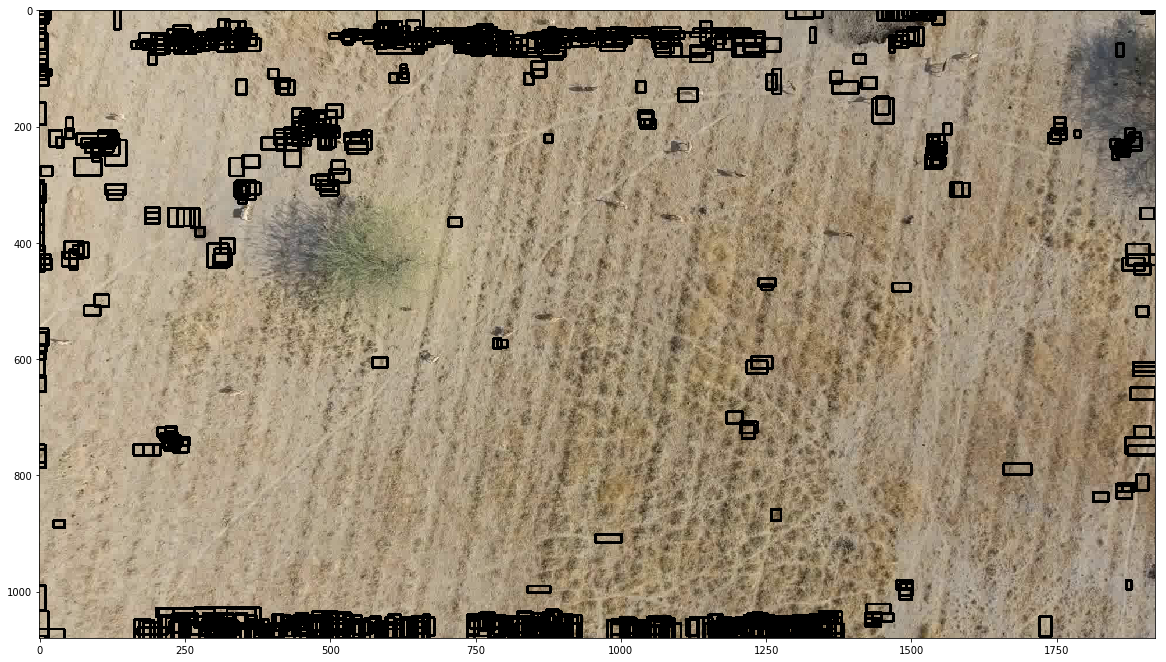

In [16]:


img = cv2.imread(image_name)#1077.JPG') #1149.JPG')


image = img[0:IMAGE_H, 0:IMAGE_W,:]
#image = img[IMAGE_H:, 0:IMAGE_W,:]
#image = img[0:IMAGE_H, IMAGE_W:,:]
#image = img[IMAGE_H:, IMAGE_W:,:]
for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))
    cert = 2*255*(box[4]-0.5)
    
    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,cert), 4)
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
#cv2.imwrite('43.JPG',image)
plt.show()


In [9]:
import tensorflow as tf 
tf.__version__

'1.4.1'

In [41]:
new_boxes[:,4]

array([ 0.69517022,  0.82478267,  0.80736727,  0.978526  ,  0.94883031,
        0.94691521,  0.85646468,  0.649813  ,  0.85160339,  0.76001811,
        0.95037848,  0.87011182,  0.956047  ,  0.99487853,  0.95216274,
        0.81708282,  0.86913955,  0.9506892 ,  0.72932678,  0.84465182,
        0.91758531,  0.74604815,  0.83091164,  0.84116906,  0.73320878,
        0.51317799,  0.92307848,  0.83062965,  0.59811354,  0.8367812 ,
        0.73042887,  0.92999697,  0.90135419,  0.95329589,  0.72401458,
        0.95799983,  0.82293046,  0.93904656,  0.74948853,  0.75516897,
        0.92221743,  0.98715705,  0.68344384,  0.87201005,  0.82672387,
        0.76844364,  0.96423429,  0.93941092,  0.90431845,  0.69784528,
        0.86667991,  0.98721981,  0.80008519,  0.85612971,  0.90366477,
        0.93219113,  0.90531588,  0.92611355,  0.89411068,  0.90778863,
        0.90057498,  0.95176917,  0.90198648,  0.78163987,  0.95690835,
        0.93209034,  0.89329487,  0.62004071,  0.8536129 ,  0.57

In [20]:
4912/32


153.5

In [21]:
len(new_boxes)

350

In [40]:
cert

103.75074237585068